In [ ]:
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.models import Model


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
df=pd.read_csv('Train.csv')

In [ ]:
df.shape

(39720, 2)

In [ ]:
import re
text_column = df['text'].astype(str)
special_char_pattern = r'[^A-Za-z]'
matches = text_column.apply(lambda x: re.findall(special_char_pattern, x))
matches_flat = [char for sublist in matches for char in sublist]
print(set(matches_flat))


{'Ż', '#', 'Ö', 'ô', ']', '¨', '/', 'ã', '®', '-', '8', '\x97', '…', '\x8d', 'י', '¢', '9', ':', 'ý', 'Å', '"', 'å', '°', '、', 'ç', '@', '₤', '}', '[', '*', '\x10', 'ו', '\x8e', '½', 'ō', '+', '4', 'ó', ')', '^', '?', 'ü', '“', '¤', 'é', '”', '~', '★', '3', 'א', 'à', 'ñ', 'À', 'ö', 'º', ' ', 'ò', '\x85', '\uf0b7', '\x96', '=', '`', '!', 'Ã', '7', '\t', '\x95', '³', '¿', 'ë', '\\', '¦', 'Ê', 'Õ', 'כ', '，', '%', 'È', '6', "'", 'ל', 'Ç', 'û', '·', '1', 'ï', '<', '{', '»', 'É', 'æ', 'ê', 'ø', '\x80', 'ú', 'ð', '\xa0', 'Ï', ',', 'Ü', '£', 'â', 'ג', '\xad', 'ß', '0', 'Ä', 'ä', 'ğ', 'ì', 'ı', 'Â', '´', 'מ', '¾', 'ר', '’', '|', 'Á', 'Æ', '–', ';', 'ù', '¡', 'Þ', '.', '\x9e', 'ן', '$', '(', '«', '\x91', 'í', 'Ó', 'á', 'è', '\x84', '§', '>', '2', 'î', '_', '&', '5', '″', '‘', '\x9a'}


In [ ]:
def data_processing(text):
    text= text.lower()
    text = re.sub('<br />', '', text) #used in html
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE) #To remove url from text
    text = re.sub(r'\@w+|\#', '', text) # to remove @ and #
    text = re.sub(r'[^\w\s]', '', text) #removes all non-alphanumeric characters and non-whitespace characters
    clean_text = re.sub('<.*?>', '', text) #remove HTML tags
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stopwords] #Remove all stops words
    return " ".join(filtered_text)

In [ ]:
df.text = df['text'].apply(data_processing)

In [ ]:
# Iterate over the first 20 rows in the 'text' column of the DataFrame
for index, row in df.head(20).iterrows():
    original_text = row['text']
    processed_text = data_processing(original_text)

    print(f"Index: {index}")
    print("Original Text:")
    print(original_text)
    print("\nProcessed Text:")
    print(processed_text)
    print("\n")


Index: 0
Original Text:
grew b 1965 watching loving thunderbirds mates school watched played thunderbirds school lunch school wanted virgil scott one wanted alan counting 5 became art form took children see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune could compare original score thunderbirds thankfully early saturday mornings one television channel still plays reruns series gerry anderson wife created jonatha frakes hand directors chair version completely hopeless waste film utter rubbish cgi remake may acceptable replacing marionettes homo sapiens subsp sapiens huge error judgment

Processed Text:
grew b 1965 watching loving thunderbirds mates school watched played thunderbirds school lunch school wanted virgil scott one wanted alan counting 5 became art form took children see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune could compare original score thunderbirds thankfully early saturd

In [ ]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [ ]:
df.text = df['text'].apply(lambda x: stemming(x))


In [ ]:
df.duplicated().sum()

280

In [ ]:
df = df.drop_duplicates('text')

In [ ]:
pos_reviews =  df[df.label == 1]
pos_reviews.head()

,text,label
4,im die hard dads army fan nothing ever change ...,1
6,finally watched shocking movie last night dist...,1
8,may remake 1987 autumns tale eleven years dire...,1
9,super ex girlfriend turned pleasant surprise r...,1
10,cant believe people looking plot film laural h...,1


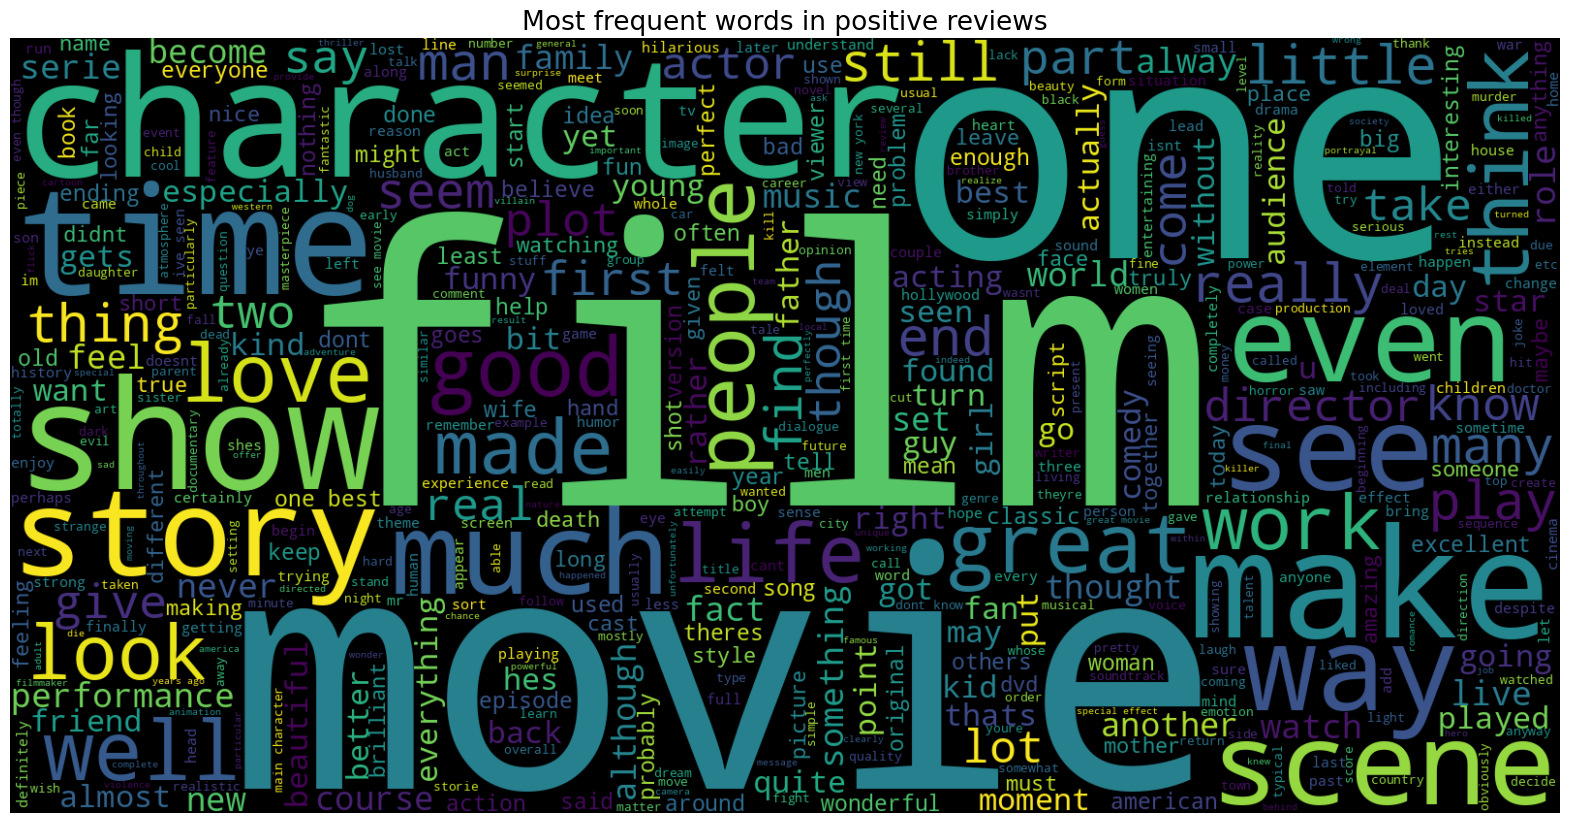

In [ ]:
from wordcloud import WordCloud

text = ' '.join([word for word in pos_reviews['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in positive reviews', fontsize = 19)
plt.show()

In [ ]:
from collections import Counter
count = Counter()
for text in pos_reviews['text'].values:
    for word in text.split():
        count[word] +=1
count.most_common(15)

[('film', 31315),
 ('movie', 28806),
 ('one', 20547),
 ('like', 13728),
 ('good', 11456),
 ('great', 10055),
 ('story', 9863),
 ('see', 9469),
 ('time', 9376),
 ('well', 8756),
 ('really', 8584),
 ('also', 8561),
 ('would', 8285),
 ('even', 7504),
 ('much', 7177)]

In [ ]:
neg_reviews =  df[df.label == 0]
neg_reviews.head()

,text,label
0,grew b 1965 watching loving thunderbirds mates...,0
1,put movie dvd player sat coke chips expectatio...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movies bor...,0
5,terrible movie everyone said made laugh cameo ...,0


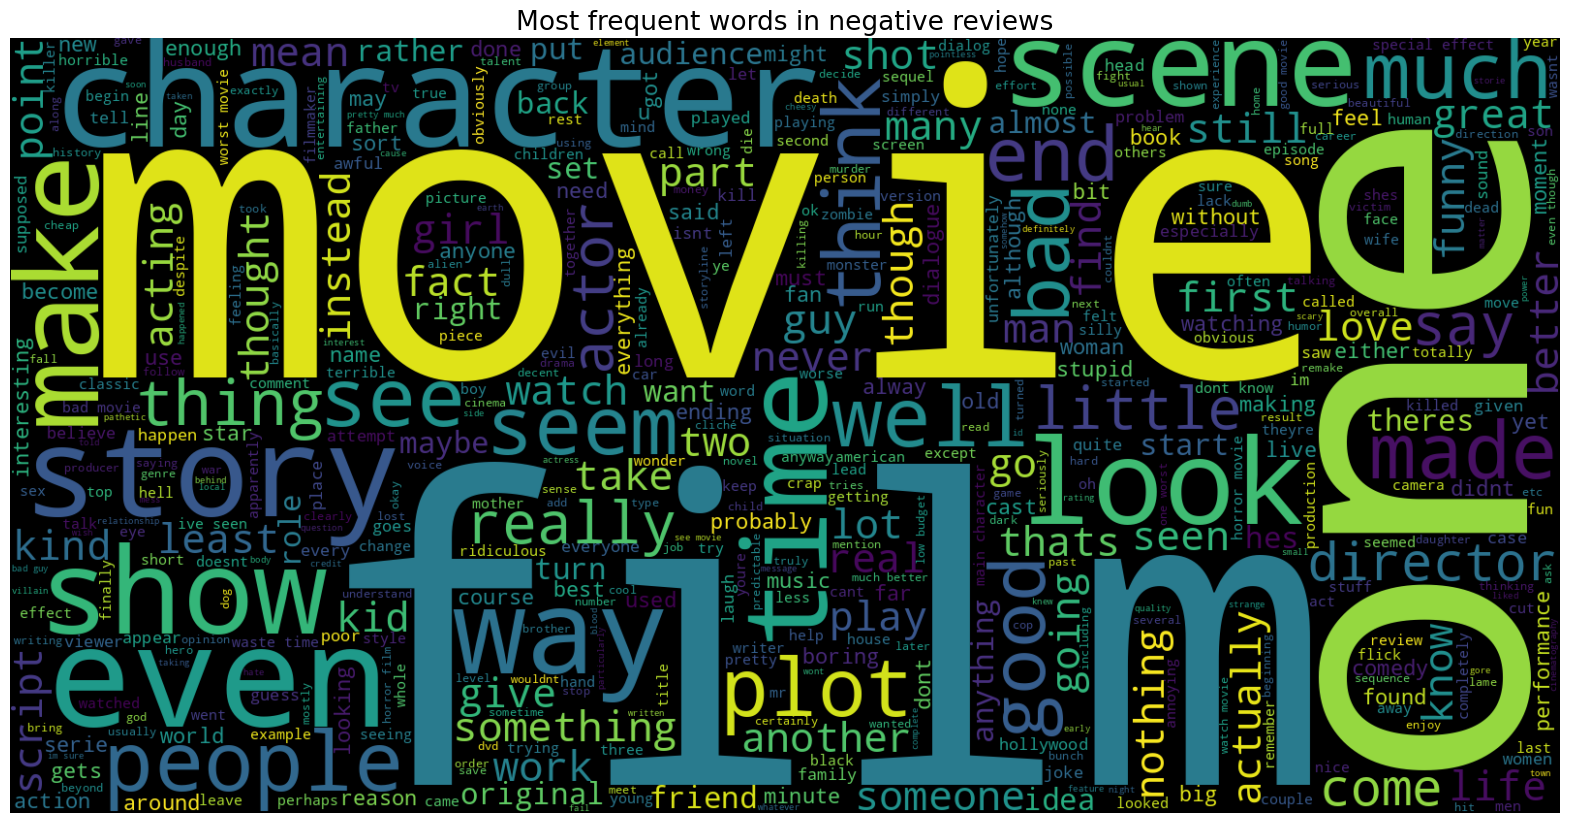

In [ ]:
text = ' '.join([word for word in neg_reviews['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most frequent words in negative reviews', fontsize = 19)
plt.show()

In [ ]:
from collections import Counter
count = Counter()
for text in neg_reviews['text'].values:
    for word in text.split():
        count[word] +=1
count.most_common(20)

[('movie', 37686),
 ('film', 27803),
 ('one', 19516),
 ('like', 17253),
 ('even', 11841),
 ('good', 11319),
 ('bad', 11105),
 ('would', 10777),
 ('really', 9702),
 ('time', 9155),
 ('see', 8312),
 ('dont', 7935),
 ('get', 7930),
 ('much', 7826),
 ('story', 7662),
 ('people', 7210),
 ('make', 7159),
 ('could', 7133),
 ('movies', 6643),
 ('made', 6596)]

In [ ]:
df

,text,label
0,grew b 1965 watching loving thunderbirds mates...,0
1,put movie dvd player sat coke chips expectatio...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movies bor...,0
4,im die hard dads army fan nothing ever change ...,1
...,...,...
39995,western union something forgotten classic west...,1
39996,movie incredible piece work explores every noo...,1
39997,wife watched movie plan visit sicily stromboli...,0
39998,first watched flatliners amazed necessary feat...,1


In [ ]:
X = df['text']
Y = df['label']

In [ ]:
count = CountVectorizer()
word_count=count.fit_transform(df.text)
print(word_count)
X = df['text']
Y = df['label']

  (0, 73658)	1
  (0, 1268)	1
  (0, 184408)	1
  (0, 101285)	1
  (0, 171358)	3
  (0, 105248)	1
  (0, 147690)	3
  (0, 184364)	1
  (0, 129897)	1
  (0, 101774)	1
  (0, 183697)	2
  (0, 182471)	1
  (0, 148123)	1
  (0, 121167)	2
  (0, 7763)	1
  (0, 38987)	1
  (0, 18175)	1
  (0, 13041)	1
  (0, 66052)	1
  (0, 173163)	1
  (0, 31885)	1
  (0, 149252)	1
  (0, 112156)	1
  (0, 81523)	1
  (0, 189436)	1
  :	:
  (39719, 143066)	1
  (39719, 49037)	1
  (39719, 102699)	1
  (39719, 117330)	1
  (39719, 35691)	1
  (39719, 159959)	1
  (39719, 26692)	1
  (39719, 156223)	1
  (39719, 109326)	1
  (39719, 73936)	1
  (39719, 175227)	1
  (39719, 115101)	1
  (39719, 3637)	1
  (39719, 12301)	1
  (39719, 10178)	1
  (39719, 30193)	1
  (39719, 31710)	1
  (39719, 19239)	1
  (39719, 167487)	1
  (39719, 188374)	1
  (39719, 32731)	1
  (39719, 174735)	1
  (39719, 56841)	1
  (39719, 158477)	1
  (39719, 3715)	1


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.30)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_vocab = 150000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(x_train)

2024-05-04 23:32:37.020238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 23:32:37.020343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 23:32:37.167116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
wordidx = tokenizer.word_index
V = len(wordidx)
print('The size of datatset vocab is: ', V)

The size of datatset vocab is:  153372


In [ ]:
train_seq = tokenizer.texts_to_sequences(x_train)
test_seq = tokenizer.texts_to_sequences(x_test)
print('Training sequence: ', train_seq[0])
print('Testing sequence: ', test_seq[0])

Training sequence:  [100, 31, 32854, 37601, 70, 100, 115, 1241, 7984, 122, 49, 19234, 725, 292, 7985, 687, 1554, 1528, 874, 1746, 5051, 1746, 282, 70, 2522, 2315, 177, 6765, 3897, 29358, 22995, 6877, 4109, 1015, 1946, 651, 354, 284, 482, 961, 5126, 1216, 7, 68, 68, 482, 961, 34, 507, 833, 1, 37, 122, 37, 27, 60716, 608, 173, 45070, 24672, 961, 5747, 43, 3, 45071, 45072, 147, 19235, 60717, 223, 2882, 8125, 6138, 2441, 235, 991, 246, 2912, 2441, 662, 930, 108, 4804, 5000, 1532, 398, 2617, 577, 224, 6656, 203, 148, 5802, 543, 15419, 4381, 8569, 1820, 12591, 2162, 1584, 60718, 123, 15419, 938, 45072, 17, 57, 54, 454, 398, 614, 29358, 961, 596, 19, 247, 6657, 992, 5294, 27, 1567, 4460, 182, 4417, 12592, 117, 57, 6, 199, 172, 3, 182, 19, 546, 329, 1809, 29358, 4238, 733, 1, 961, 3263, 34, 507, 1275, 151, 19, 76, 3, 477, 105, 1773, 26, 5567, 27, 23, 124, 116, 2984, 300, 297, 2110, 7058, 1947, 104, 179, 1261, 1003, 27, 565, 12, 116, 279, 877, 151, 961, 124, 1344, 5568, 47, 275, 249, 365, 1125,

In [ ]:
pad_train = pad_sequences(train_seq)
T = pad_train.shape[1]
print('The length of training sequence is: ', T)

# padding the test sequence
pad_test = pad_sequences(test_seq, maxlen=T)
print('The length of testing sequence is: ', pad_test.shape[1])


The length of training sequence is:  1165
The length of testing sequence is:  1165


In [ ]:
D = 20 # represents the dimensionality of the word embeddings
M = 15  #Number of units in LSTM
i = Input (shape=(T, ))
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

r = model.fit(pad_train, y_train, validation_data=(pad_test, y_test), epochs=5)

Epoch 1/5
869/869 ━━━━━━━━━━━━━━━━━━━━ 45s 47ms/step - accuracy: 0.7138 - loss: 0.5083 - val_accuracy: 0.8833 - val_loss: 0.2828
Epoch 2/5
869/869 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9532 - loss: 0.1381 - val_accuracy: 0.8803 - val_loss: 0.3395
Epoch 3/5
869/869 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9861 - loss: 0.0504 - val_accuracy: 0.8740 - val_loss: 0.3895
Epoch 4/5
869/869 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9941 - loss: 0.0200 - val_accuracy: 0.8682 - val_loss: 0.4898
Epoch 5/5
869/869 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.9975 - loss: 0.0084 - val_accuracy: 0.8625 - val_loss: 0.5053


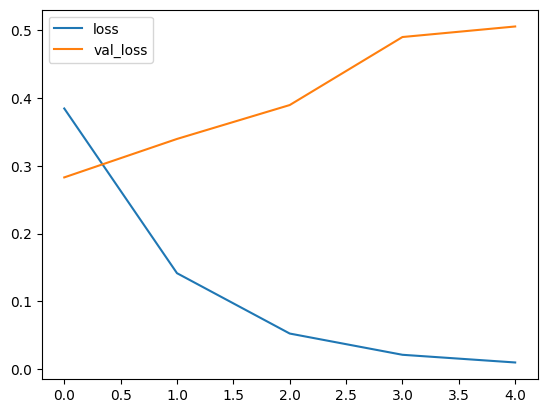

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()


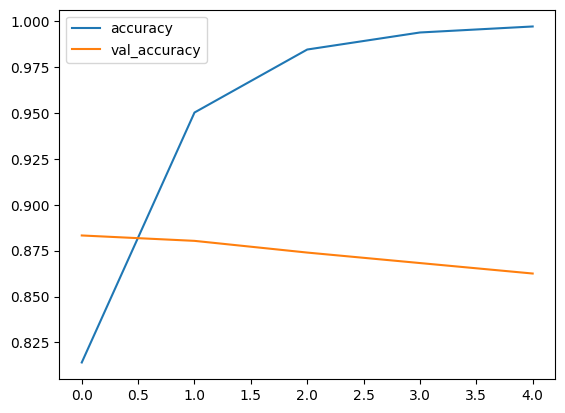

In [ ]:
plt.plot(r.history['accuracy'], label= 'accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
def predict_sentiment(text):
    text_seq = tokenizer.texts_to_sequences(text)
    text_pad = pad_sequences(text_seq, maxlen=T)

    predicted_sentiment = model.predict(text_pad).round()

    if predicted_sentiment == 1.0:
        return(print('It is a positive sentiment'))
    else:
        return(print('It is a negative sentiment'))

text = ['The movie was very good']
predict_sentiment(text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
It is a positive sentiment
